In [2]:
import math
import arrow

import ipynb 
import os.path
import json
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from dotenv import load_dotenv
from networkx.algorithms import bipartite
from importlib import reload

from typing import List


In [32]:
# import functions from py file 

import function
reload(function)
from function import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from function import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict
from function import extract_classes_company_tech, degree_bip, insert_data_classes

In [4]:
# import classes 

import classes
reload(classes)
from classes import Company, Investor, Technology

### Download data from CSV

In [5]:
df_start = pd.read_csv("data/data_cb/organizations.csv")

In [6]:
df_start.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,legal_name,roles,...,phone,facebook_url,linkedin_url,twitter_url,logo_url,alias1,alias2,alias3,primary_role,num_exits
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,wetpaint,https://www.crunchbase.com/organization/wetpaint,158955.0,2007-05-25 13:51:27,2019-06-24 22:19:25,NaN,company,...,206-859-6300,https://www.facebook.com/Wetpaint,https://www.linkedin.com/company/wetpaint,https://twitter.com/wetpainttv,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,zoho,https://www.crunchbase.com/organization/zoho,6686.0,2007-05-26 02:30:28,2018-10-27 00:29:49,NaN,"investor,company",...,NaN,http://www.facebook.com/zoho,http://www.linkedin.com/company/zoho-corporati...,http://twitter.com/zoho,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,1.0
2,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,digg,https://www.crunchbase.com/organization/digg,7793.0,2007-05-26 03:03:23,2018-12-10 10:09:14,"Digg Holdings, LLC",company,...,877-342-7222,http://www.facebook.com/digg,http://www.linkedin.com/company/digg,http://twitter.com/digg,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN
3,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,omidyar-network,https://www.crunchbase.com/organization/omidya...,136861.0,2007-05-26 03:21:34,2019-06-19 12:17:48,NaN,investor,...,650.482.2500,http://www.facebook.com/OmidyarNetwork,http://www.linkedin.com/company/22806,http://twitter.com/OmidyarNetwork,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,investor,38.0
4,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,organization,facebook,https://www.crunchbase.com/organization/facebook,47.0,2007-05-26 04:22:15,2021-04-14 23:52:25,"Facebook, Inc.","investor,company",...,NaN,https://www.facebook.com/facebook/,http://www.linkedin.com/company/facebook,https://twitter.com/facebook,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN


In [7]:
# df_start["category_list"]

In [8]:
# df_start["category_groups_list"]

In [9]:
df_start.columns

Index(['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at',
       'updated_at', 'legal_name', 'roles', 'domain', 'homepage_url',
       'country_code', 'state_code', 'region', 'city', 'address',
       'postal_code', 'status', 'short_description', 'category_list',
       'category_groups_list', 'num_funding_rounds', 'total_funding_usd',
       'total_funding', 'total_funding_currency_code', 'founded_on',
       'last_funding_on', 'closed_on', 'employee_count', 'email', 'phone',
       'facebook_url', 'linkedin_url', 'twitter_url', 'logo_url', 'alias1',
       'alias2', 'alias3', 'primary_role', 'num_exits'],
      dtype='object')

### Data Cleaning

for now we decide to use as key the name. it would be better to use the uuid

In [10]:
to_drop = [
    'type',
    'permalink',
    'cb_url',   
    'created_at',
    'domain',
    'address',
    'state_code',
    'updated_at',
    'legal_name',
    'roles',
    'postal_code',
    'homepage_url',
    'num_funding_rounds',
    'total_funding_currency_code',
    'phone',
    'email',
    'num_exits',
    'alias2',
    'alias3',
    'num_exits',
    'logo_url',
    'alias1',
    'last_funding_on',
    'twitter_url',
    'facebook_url'
]

# to_rename = { 'category_groups_list': 'category_groups' }
to_rename = { 'category_list': 'category_groups' }

drop_if_nan = [
    'category_groups',
    'rank',
    'short_description'
]

to_check_double = {}

sort_by = "rank"

In [11]:
df = CB_data_cleaning(df_start, to_drop, to_rename, to_check_double, drop_if_nan, sort_by)

In [12]:
df.head()

,uuid,name,rank,country_code,region,city,status,short_description,category_groups,category_groups_list,total_funding_usd,total_funding,founded_on,closed_on,employee_count,linkedin_url,primary_role
1178,74a20af3-f4dd-6188-de60-c4ee6cd0ca4a,Ant Group,1.0,CHN,Zhejiang,Hangzhou,operating,Ant Group strives to enable all consumers and ...,"Banking,Financial Services,FinTech,Payments","Financial Services,Lending and Investments,Pay...",2.200000e+10,2.200000e+10,2014-10-01,NaN,5001-10000,https://www.linkedin.com/company/antgroup/,company
4042,022417b5-4980-6c54-0f3c-6736bbbb1a5e,Spotify,2.0,SWE,Stockholms Lan,Stockholm,ipo,Spotify is a commercial music streaming servic...,"Audio,Cloud Computing,Music,Music Streaming,Vi...","Content and Publishing,Internet Services,Media...",2.085425e+09,2.085425e+09,2006-04-23,NaN,5001-10000,http://www.linkedin.com/company/spotify,company
349,468bef9f-2f50-590e-6e78-62e3adb05aa1,Citi,3.0,USA,New York,New York,ipo,Citigroup is a diversified financial services ...,"Banking,Credit Cards,Financial Services,Wealth...","Financial Services,Lending and Investments,Pay...",8.700000e+09,8.700000e+09,1998-10-08,NaN,10000+,https://www.linkedin.com/company/citi,investor
211260,a40d0a1f-f32c-a1e9-1bbd-a10bb0eca2e7,Deliveroo,4.0,GBR,England,London,ipo,Deliveroo is an online food delivery service t...,"Delivery,Food and Beverage,Food Delivery,Same ...","Administrative Services,Food and Beverage,Tran...",1.712683e+09,1.712683e+09,2012-01-01,NaN,5001-10000,https://www.linkedin.com/company/deliveroo,company
621119,00daca16-8311-454b-84e0-24a40d16be9c,Antler,5.0,SGP,Central Region,Singapore,operating,Antler is a global early-stage venture capital...,Venture Capital,"Financial Services,Lending and Investments",7.800000e+07,7.800000e+07,2017-01-01,NaN,101-250,https://www.linkedin.com/company/antlerglobal/,investor


In [13]:
df.columns

Index(['uuid', 'name', 'rank', 'country_code', 'region', 'city', 'status',
       'short_description', 'category_groups', 'category_groups_list',
       'total_funding_usd', 'total_funding', 'founded_on', 'closed_on',
       'employee_count', 'linkedin_url', 'primary_role'],
      dtype='object')

In [14]:
# convert category_groups to list

def convert_to_list(string):
    li = list(string.split(","))
    return li
  
if type(df["category_groups"][df.index[0]]) != list:
    df["category_groups"] = [convert_to_list(x) for x in df["category_groups"]]

### Select cybersecurity

In [15]:
cybersecurity_words = [
    "cybersecurity"
    "confidentiality",
    "integrity",
    "availability",
    "secure",
    "security",
    "safe",
    "reliability",
    "dependability",
    "confidential",
    "confidentiality",
    "integrity",
    "availability",
    "defense",
    "defence",
    "defensive",
    "privacy"
]

In [19]:
def check_desc(line, words):
    if isinstance(line, float):
        return False
    
    #print(sum(w in line for w in words))
    
    if sum(w in line for w in words)>1:
    #if any(w in line for w in words):
        return True
    return False

In [20]:
df = df.loc[df["short_description"].apply(lambda x: check_desc(x, cybersecurity_words))]

In [21]:
#list(df["short_description"])

### Extract categories:

In [22]:
#list(df["category_groups"])

### Create Companies and Technologies classes

#### Ranking

I personally appreciate the ranking that you provide for each company. However, I did not quite understand what's the magic behind it. Is there any chance to get some more insight/details, also considering that we do have an NDA in place?

- Crunchbase rank uses Crunchbase’s intelligent algorithms to score and rank entities (e.g. Company, People, Investors, etc.).
- The algorithms take into account many different variables; ranging from funding events, the entity’s strength of relationships with other entities in the Crunchbase ecosystem, the level of engagement from our website, news articles, and acquisitions.

    - A company’s Rank is fluid and subject to rising and decaying over time with time-sensitive events. Events such as product launches, funding events, leadership changes, and news affect a company’s Crunchbase Rank.


- The Crunchbase rank shows where an entity falls in the Crunchbase database relative to all other entities in that entity type (i.e. if searching for companies, you will see where a specific company ranks relative to all other companies). An entity with a Crunchbase Rank of 1 has the highest rank relative to all other entities of that type.

I would also suggest leveraging our Trend Score - 7 Day, 30 Day, 90 Day (e.g. Company, People, Investors, etc.)

- While Rank shows context, Crunchbase Trend Score demonstrates activity. A company’s rank will change based on activity (fundraising, news, etc.) and Trend Score is an indicator of how much their rank is changing at any given time.
- Crunchbase Trend Score tracks the fluctuations in Rank. As a company’s rank changes, so do its Trend Score.
- Trend Score measures the rate of a company’s activity on a 20-point (+10 <-> -10) scale. Scores closer to +10 mean it’s moving up in rank much faster compared to their peers. Scores closer to -10 mean it’s moving down.
- For example, a company that announces its first funding round will likely experience a jump in its Rank, pushing its Trend Score up as its page views, article counts, funding amount, team members, etc., begin to increase.


In [23]:
len(df)

2444

In [24]:
#list(df["short_description"])

### Set limits

In [25]:
# df = df[:100]

### Create graph

In [112]:
[dict_companies, dict_tech, B] = extract_classes_company_tech(df)

In [113]:
print(f"We have {len(dict_companies)} companies and {len(dict_tech)} technologies")

We have 2443 companies and 478 technologies


### Plots

In [114]:
"""plot_bipartite_graph(B, small_degree=True)
plt.savefig(f'plots_net/network_all_{str(len(df))}.pdf')
plt.savefig(f'plots_net/network_all_{str(len(df))}.png')"""

"plot_bipartite_graph(B, small_degree=True)\nplt.savefig(f'plots_net/network_all_{str(len(df))}.pdf')\nplt.savefig(f'plots_net/network_all_{str(len(df))}.png')"

In [115]:
"""plot_bipartite_graph(B, small_degree=True, circular=True)
plt.savefig(f'plots_net/network_all_circ_{str(len(df))}.pdf')
plt.savefig(f'plots_net/network_all_circ_{str(len(df))}.png')"""

"plot_bipartite_graph(B, small_degree=True, circular=True)\nplt.savefig(f'plots_net/network_all_circ_{str(len(df))}.pdf')\nplt.savefig(f'plots_net/network_all_circ_{str(len(df))}.png')"

In [319]:
# import functions from py file 

import function
reload(function)
from function import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from function import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict
from function import extract_classes_company_tech, degree_bip, insert_data_classes

In [320]:
percentagee = 57

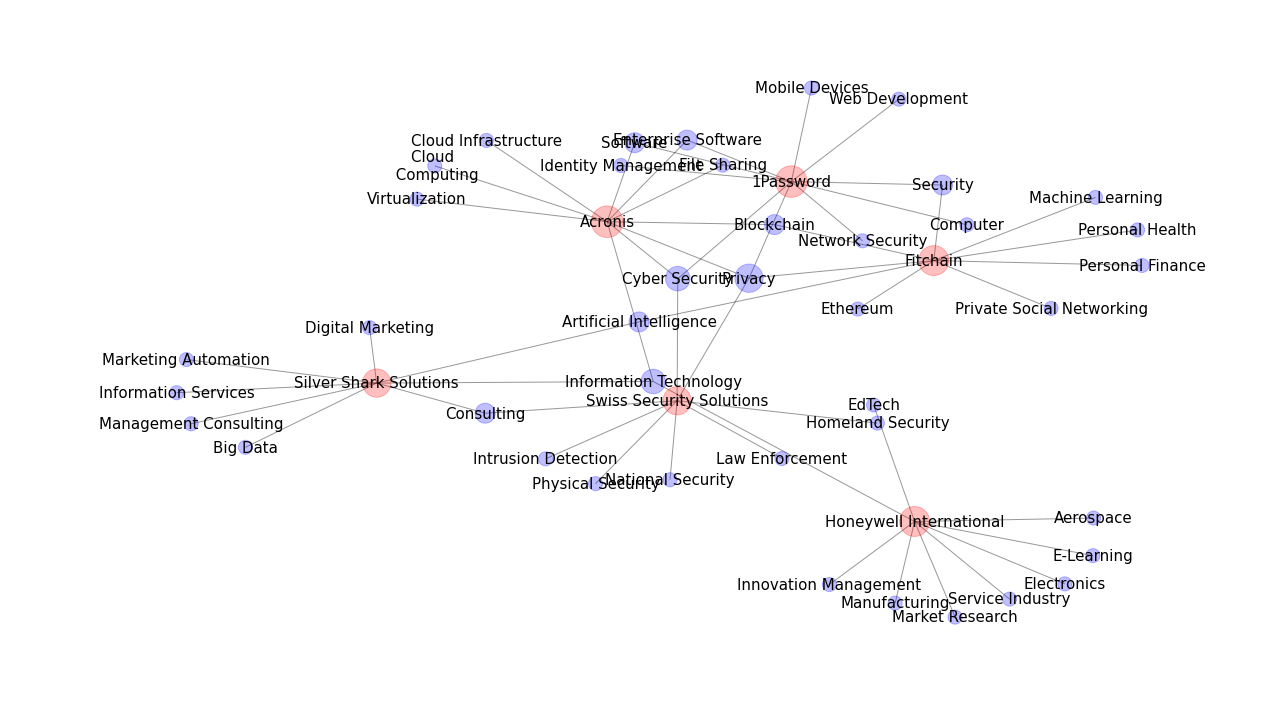

In [316]:
pos2 = plot_bipartite_graph(B, small_degree=False, percentage=percentagee)
plt.savefig(f'plots_net/network_{str(percentagee)}_{str(len(df))}.pdf')
plt.savefig(f'plots_net/network_{str(percentagee)}_{str(len(df))}.png')

In [323]:
pos = pos3

In [379]:
pos3

{'Privacy': array([-0.07262748, -0.09021161]),
 'Software': array([ 0.40412562, -0.36368407]),
 'Artificial Intelligence': array([-0.53833836, -0.392145  ]),
 'Big Data': array([-0.16851475, -0.76132566]),
 'Cyber Security': array([ 0.07471265, -0.0508622 ]),
 'Enterprise Software': array([ 0.34760492, -0.43275461]),
 'Security': array([-0.06648947, -0.20181292]),
 'Acronis': array([ 0.12796667, -0.37626624]),
 'Blockchain': array([-0.22174032, -0.30398643]),
 'Cloud \n Computing': array([ 0.16745255, -0.7076293 ]),
 'Cloud Infrastructure': array([ 0.36964052, -0.6239994 ]),
 'File Sharing': array([ 0.3797717 , -0.69674875]),
 'Information Technology': array([0.10177341, 0.05850177]),
 'Network Security': array([ 0.66099841, -0.07286232]),
 '1Password': array([ 0.37001274, -0.20162002]),
 'Computer': array([ 0.71252286, -0.18465755]),
 'Identity Management': array([ 0.70421734, -0.29930389]),
 'Mobile Devices': array([ 0.39763261, -0.0242841 ]),
 'Web Development': array([ 0.65046179, 

In [347]:
pos3

{'Privacy': array([-0.07262748, -0.09021161]),
 'Software': array([ 0.40412562, -0.36368407]),
 'Artificial Intelligence': array([-0.53833836, -0.392145  ]),
 'Big Data': array([-0.16851475, -0.76132566]),
 'Cyber Security': array([ 0.07471265, -0.0508622 ]),
 'Enterprise Software': array([ 0.34760492, -0.43275461]),
 'Security': array([-0.06648947, -0.20181292]),
 'Acronis': array([ 0.12796667, -0.37626624]),
 'Blockchain': array([-0.22174032, -0.30398643]),
 'Cloud \n Computing': array([ 0.16745255, -0.7076293 ]),
 'Cloud Infrastructure': array([ 0.36964052, -0.6239994 ]),
 'File Sharing': array([ 0.2797717 , -0.69674875]),
 'Information Technology': array([0.10177341, 0.05850177]),
 'Network Security': array([ 0.66099841, -0.07286232]),
 '1Password': array([ 0.37001274, -0.20162002]),
 'Computer': array([ 0.71252286, -0.18465755]),
 'Identity Management': array([ 0.70421734, -0.29930389]),
 'Mobile Devices': array([ 0.39763261, -0.0242841 ]),
 'Web Development': array([ 0.65046179, 

In [380]:
honey = [
    'Market Research',
    'Honeywell International',
    'E-Learning',
    'EdTech',
    'Electronics',
    'Service Industry',
    'Aerospace',
    'Manufacturing',
    'Innovation Management'
]

In [381]:
for h in honey:
    position = pos3[h]
    position[1] = position[1]- 0.2
    pos3[h] = position

In [364]:
mapping = {
    'Swiss Security Solutions LLC': "Swiss Security Solutions", 
    'fitchain': "Fitchain",
    'Cloud Computing':'Cloud \n Computing',
    'Law Enforcement':'Law \n Enforcement',
    'Physical Security':'Physical \n Security',
    'National Security':'National \n Security',
    'Management Consulting': 'Management \n Consulting'
}

B = nx.relabel_nodes(B, mapping)

In [341]:
pos3['Management \n Consulting'] = pos3['Management Consulting']
pos3.pop('Management Consulting')

array([-0.05817977, -0.595898  ])

In [438]:
h = 'Law \n Enforcement'
position = pos3[h]
position[0] = position[0] + 0.05
pos3[h] = position

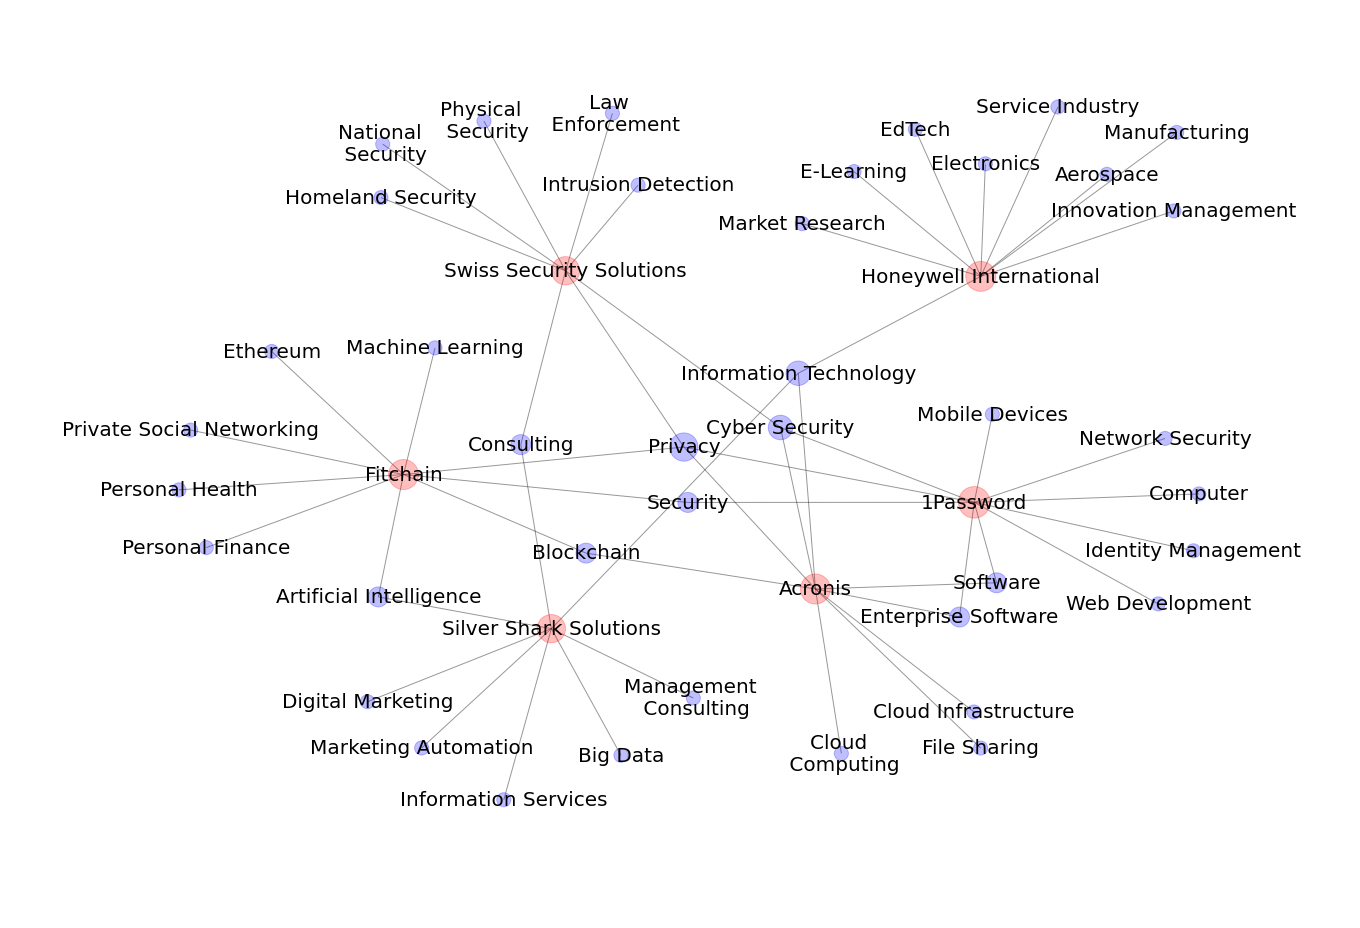

In [439]:
plot_bipartite_graph1(pos3, B, small_degree=False, percentage=percentagee)

plt.savefig(f'plots_net/network_finished.pdf')
plt.savefig(f'plots_net/network_finished.png')

In [434]:
def plot_bipartite_graph1(pos, G, small_degree=True, percentage=10, circular=False):

    set1 = [node for node in G.nodes() if G.nodes[node]['bipartite']==0]
    set2 = [node for node in G.nodes() if G.nodes[node]['bipartite']==1]

    if small_degree == False: # don't plot nodes with low number of edges
        to_delete = filter_dict(G, percentage, set1, set2)

        G_filtered = G.copy()
        G_filtered.remove_nodes_from(to_delete)
        G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

        plot_bipartite_graph1(pos, G_filtered, small_degree=True, percentage=percentage, circular=circular)
        
        return

    if len(set1)>=20:
        plt.figure(1,figsize=(25,15))
    else: 
        plt.figure(1,figsize=(19,13)) 
    
    plt.axis('off')



    if "Social Recruiting" in G.nodes():
        G.remove_node("Social Recruiting")
    if "Mobile" in G.nodes():
        G.remove_node("Mobile")
    if "Sales" in G.nodes():
        G.remove_node("Sales")
    if "Analytics" in G.nodes():
        G.remove_node("Analytics")
    if "Government" in G.nodes():
        G.remove_node("Government")
    if "Education" in G.nodes():
        G.remove_node("Education")
    if "Personalization" in G.nodes():
        G.remove_node("Personalization")
    if "Military" in G.nodes():
        G.remove_node("Military")

    G.remove_node("Virtualization")

    # company, value = bipartite.sets(G)
    # subsituted with:
    company = [node for node in G.nodes() if G.nodes[node]['bipartite']==0]
    value = [node for node in G.nodes() if G.nodes[node]['bipartite']==1]

    # calculate degree centrality
    companyDegree = nx.degree(G, company) 
    valueDegree = nx.degree(G, value)


    # nodes
    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=company,
                           node_color='r',
                           node_size=[v * 100 for v in dict(companyDegree).values()],
                           alpha=0.25,
                           label=company)

    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=value,
                           node_color='b',
                           node_size=[v * 200 for v in dict(valueDegree).values()],
                           alpha=0.25,
                           label=value)

    nx.draw_networkx_labels(G, pos, {n: n for n in company}, font_size=20)
    nx.draw_networkx_labels(G, pos, {n: n for n in value}, font_size=20)

    # edges
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.4)


    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()

    return 


In [193]:
"""plot_bipartite_graph(B, small_degree=False, circular=True, percentage=percentagee)
plt.savefig(f'plots_net/network_{str(percentagee)}_circ_{str(len(df))}.pdf')
plt.savefig(f'plots_net/network_{str(percentagee)}_circ_{str(len(df))}.png')"""

"plot_bipartite_graph(B, small_degree=False, circular=True, percentage=percentagee)\nplt.savefig(f'plots_net/network_{str(percentagee)}_circ_{str(len(df))}.pdf')\nplt.savefig(f'plots_net/network_{str(percentagee)}_circ_{str(len(df))}.png')"

In [174]:
[company_degree, tech_degree] = degree_bip(B)

In [ ]:
print(f"We have {len(company_degree)} companies and {len(tech_degree)} technologies")

In [ ]:
# sort by value
company_degree_sorted = dict(sorted(company_degree.items(), key=lambda item: item[1], reverse=True))
tech_degree_sorted = dict(sorted(tech_degree.items(), key=lambda item: item[1], reverse=True))

# only maximum 
num_max = 10


# check we don't go out of range
if len(company_degree)<num_max or len(tech_degree)<num_max:
    minn = min(len(company_degree), len(tech_degree))
    num_max = minn-1

def limit_value(x, num_max_perc):
    return list(x.values())[num_max_perc]

company_degree_max = {k: company_degree_sorted[k] for k in list(company_degree_sorted.keys())[:num_max]}
tech_degree_max = {k: tech_degree_sorted[k] for k in list(tech_degree_sorted.keys())[:num_max]}


In [ ]:
plt.barh(list(company_degree_max.keys()), company_degree_max.values(), color='g')
plt.grid(True)
plt.show()

In [ ]:
plt.barh(list(tech_degree_max.keys()), tech_degree_max.values(), color='g')
plt.grid(True)
plt.show()

In [ ]:
# companies' degree 
dict_companies = insert_data_classes(dict_companies, dict(company_degree), 'degree')

In [ ]:
# technologies' degree
dict_tech = insert_data_classes(dict_tech, dict(tech_degree), 'degree')

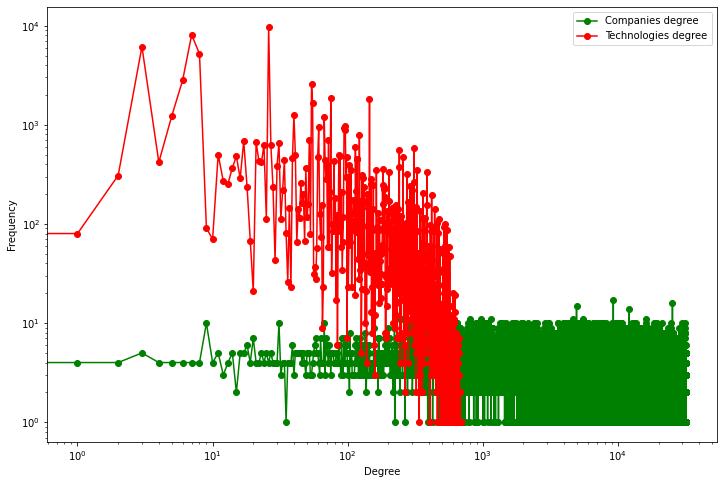

In [36]:
a = list(company_degree.values())
b = list(tech_degree.values())
degrees_a = range(len(a))
degrees_b = range(len(b))

m=0
plt.figure(figsize=(12, 8)) 
plt.loglog(degrees_a[m:], a,'go-', label='Companies degree') 
plt.loglog(degrees_b[m:], b,'ro-', label='Technologies degree') 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()

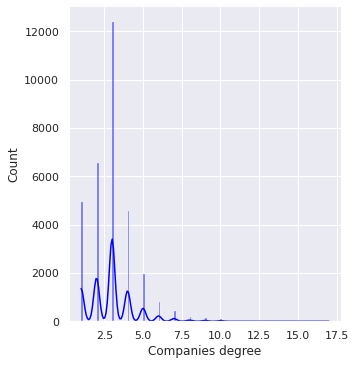

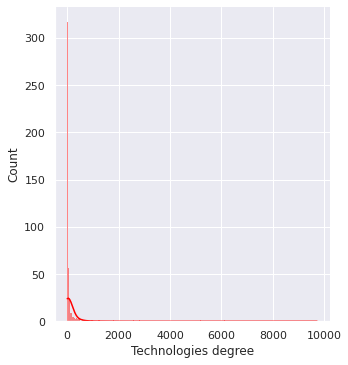

In [37]:
sns.set(style="darkgrid")
sns.displot(a, color="blue", label="Companies degree", kde=True)
plt.xlabel("Companies degree")
sns.displot(b, color="red", label="Technologies degree", kde=True)
plt.xlabel("Technologies degree")
plt.show()

### Rank

In [38]:
from networkx.algorithms.bipartite.matrix import biadjacency_matrix

In [39]:
set0 = extract_nodes(B, 0)
set1 = extract_nodes(B, 1)

# adjacency matrix of bipartite graph
adj_matrix = biadjacency_matrix(B, set0, set1)

In [40]:
adj_matrix_dense = adj_matrix.todense()

**Representation**

In [41]:
a = np.squeeze(np.asarray(adj_matrix_dense))
#a.sum(axis=1)

In [42]:
#company_degree

In [43]:
#tech_degree

In [1]:
# import functions from py file 

import functions_method_of_reflections
reload(functions_method_of_reflections)
from functions_method_of_reflections import zero_order_score, Gct_beta, Gtc_alpha, make_G_hat, next_order_score, generator_order_w
from functions_method_of_reflections import M_test_triangular, w_stream, find_convergence, rank_df_class

NameError: name 'reload' is not defined

In [ ]:
# M is the array version of the matrix adj_matrix_dense:
M = np.squeeze(np.asarray(adj_matrix_dense))

### Triangularize matrix

In [ ]:
M_test_triangular(adj_matrix_dense)

### Zero order score

These are an $w_{c}$ editor-vector which is the sums of articles edited by each editor. Or the article-vector $w_{p}$, which is the sum of editors contributing to each article.

\begin{cases}
 w_{c}^{(0)} = \sum_{p=1}^{N_{p}} M \equiv k_c\\[7pt]
 w_{p}^{(0)} = \sum_{c=1}^{N_{c}} M \equiv k_p
\end{cases}

In [47]:
k_c, k_t = zero_order_score(M)

### G - transition probability function

Depending on $\alpha$ and $\beta$ we non-linearly weight based on the Zeroth order iterations. 

\begin{cases}
G_{ct}(\beta) = \frac{M_{ct} k_{c}^{-\beta}}{\sum_{c' = 1}^{N_c} M_{c't} k_{c'}^{-\beta}}\\[10pt]
G_{tc}(\alpha) = \frac{M_{ct} k_{t}^{-\alpha}}{\sum_{t' = 1}^{N_t} M_{ct'} k_{t'}^{-\alpha}}.\\\end{cases}

### Higher cases

The first order $w^{1}_c$ is the sum of the articles touched, but weighted by the Zeroth order article-vector (and the $G$ term). So if you've edited better articles that counts. And $w^{1}_c$ is the sum of editors touching, but weighted by the Zeroth order editor-vector (and $G$). So if you're touched by better editors that's also being considered. 

Beyond the first order interpretation for the higher orders is difficult.

\begin{cases}
w^{(n+1)}_c (\alpha,\beta) = \sum_{t=1}^{N_p}  G_{ct}(\beta) \,w^{(n)}_t (\alpha,\beta)\\[7pt]
w^{(n+1)}_t (\alpha,\beta) = \sum_{c=1}^{N_c}  G_{tc}(\alpha) \, w^{(n)}_c (\alpha,\beta)\\
\end{cases}

convergence_comp = find_convergence(M, alpha=0.5, beta=0.5, fit_or_ubiq='fitness', do_plot=True)

plt.savefig(f'plots/CSV_company_rank_evolution_{str(len(df))}.pdf')
plt.savefig(f'plots/CSV_company_rank_evolution_{str(len(df))}.png')#### Companies

In [ ]:
convergence_comp = find_convergence(M, alpha=0.5, beta=0.5, fit_or_ubiq='fitness', do_plot=True)

plt.savefig(f'plots/CSV_company_rank_evolution_{str(len(df))}.pdf')
plt.savefig(f'plots/CSV_company_rank_evolution_{str(len(df))}.png')

In [ ]:
df_final_companies, dict_companies = rank_df_class(convergence_comp, dict_companies)

In [ ]:
# relative rank
df_final_companies['final_rank_normlized'] = df_final_companies['final_rank']/np.max(list(df_final_companies['final_rank']))*10
n = np.max(df_final_companies['rank_CB']) + 1
df_final_companies['rank_CB_normlized'] = n - df_final_companies['rank_CB']

df_final_companies['TeckRank_int'] = df_final_companies.index + 1.0

In [ ]:
df_final_companies

In [ ]:
df_spearman = df_final_companies[["TeckRank_int", "rank_CB_normlized"]]
df_spearman = df_spearman.astype(float)
df_spearman["name"] = df_final_companies['final_configuration']
df_spearman.set_index("name")

In [ ]:
df_spearman

In [ ]:
len(df)

In [ ]:
# save df
name = "csv_results/complete_companies_" + str(len(df)) + ".csv"
df_final_companies.to_csv(name, index = False, header=True)

**Sperman correlation**

In [ ]:
sns.lmplot(x="rank_CB_normlized", y="TeckRank_int", data=df_spearman)
plt.show()

In [ ]:
df_spearman.corr(method='spearman')

#### Technologies

In [ ]:
convergence_tech = find_convergence(M, alpha=0.5, beta=0.5, fit_or_ubiq='ubiquity', do_plot=True)

plt.savefig(f'plots/CSV_tech_rank_evolution_{str(len(df))}.pdf')
plt.savefig(f'plots/CSV_tech_rank_evolution_{str(len(df))}.png')

In [ ]:
df_final_tech, dict_tech = rank_df_class(convergence_tech, dict_tech)

In [ ]:
df_final_tech

In [ ]:
# save df
name = "csv_results/complete_tech_" + str(len(df)) + ".csv"

df_final_tech.to_csv(name, index = False, header=True)

In [ ]:
a = 0